In [1]:
import tkinter as tk
from tkinter import ttk, messagebox
import mysql.connector
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import seaborn as sns
import pickle
from datetime import datetime
from reportlab.lib.pagesizes import letter
from reportlab.pdfgen import canvas

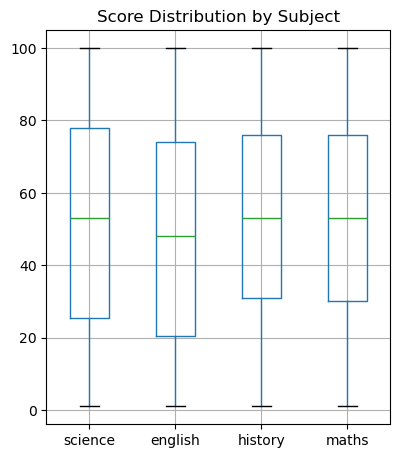

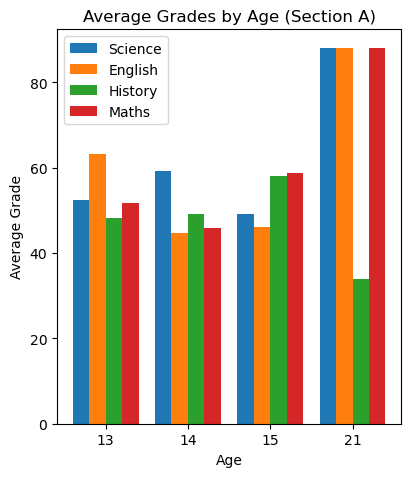

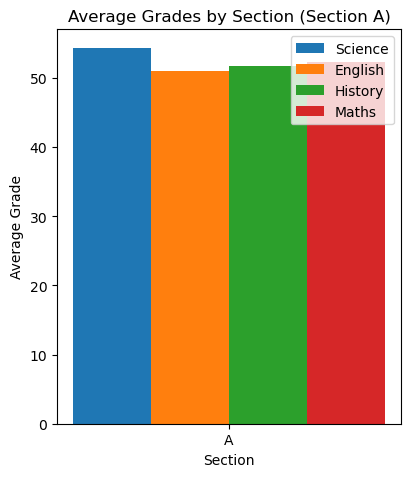

In [3]:
# Database connection
db = mysql.connector.connect(
    host="localhost",
    user="root",
    password="90190",
    database="student_db"
)
cursor = db.cursor()

# ML Model Functions
def train_maths_model():
    cursor.execute("SELECT science, english, history, maths FROM students")
    data = cursor.fetchall()
    if len(data) < 2:
        return None
    df = pd.DataFrame(data, columns=['science', 'english', 'history', 'maths'])
    X = df[['science', 'english', 'history']]
    y = df['maths']
    X_train, _, y_train, _ = train_test_split(X, y, test_size=0.2, random_state=42)
    model = LinearRegression()
    model.fit(X_train, y_train)
    return model

def train_performance_classifier():
    cursor.execute("SELECT science, english, history, maths FROM students")
    data = cursor.fetchall()
    if len(data) < 2:
        return None
    df = pd.DataFrame(data, columns=['science', 'english', 'history', 'maths'])
    df['total'] = df[['science', 'english', 'history', 'maths']].mean(axis=1)
    df['category'] = pd.cut(df['total'], bins=[0, 50, 80, 100], labels=['Poor', 'Average', 'Excellent'])
    X = df[['science', 'english', 'history', 'maths']]
    y = df['category']
    X_train, _, y_train, _ = train_test_split(X, y, test_size=0.2, random_state=42)
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)
    return model

def train_risk_model(subject):
    cursor.execute(f"SELECT science, english, history, maths FROM students")
    data = cursor.fetchall()
    if len(data) < 2:
        return None
    df = pd.DataFrame(data, columns=['science', 'english', 'history', 'maths'])
    features = [col for col in ['science', 'english', 'history', 'maths'] if col != subject]
    X = df[features]
    y = (df[subject] < 40).astype(int)
    X_train, _, y_train, _ = train_test_split(X, y, test_size=0.2, random_state=42)
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)
    return model

def train_top_performer_model():
    cursor.execute("SELECT science, english, history, maths FROM students")
    data = cursor.fetchall()
    if len(data) < 2:
        return None
    df = pd.DataFrame(data, columns=['science', 'english', 'history', 'maths'])
    df['total'] = df[['science', 'english', 'history', 'maths']].mean(axis=1)
    threshold = df['total'].quantile(0.9)
    df['top_performer'] = (df['total'] >= threshold).astype(int)
    X = df[['science', 'english', 'history', 'maths']]
    y = df['top_performer']
    X_train, _, y_train, _ = train_test_split(X, y, test_size=0.2, random_state=42)
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)
    return model

def train_career_prediction_model():
    cursor.execute("SELECT science, english, history, maths FROM students")
    data = cursor.fetchall()
    if len(data) < 2:
        return None
    df = pd.DataFrame(data, columns=['science', 'english', 'history', 'maths'])
    X = df[['science', 'english', 'history', 'maths']]
    y = np.where(df['science'] > df[['english', 'history', 'maths']].mean(axis=1), 'Science', 'Arts')
    model = DecisionTreeClassifier(random_state=42)
    model.fit(X, y)
    return model

def train_learning_style_model():
    cursor.execute("SELECT science, english, history, maths FROM students")
    data = cursor.fetchall()
    if len(data) < 2:
        return None
    df = pd.DataFrame(data, columns=['science', 'english', 'history', 'maths'])
    X = df[['science', 'english', 'history', 'maths']]
    kmeans = KMeans(n_clusters=2, random_state=42)
    kmeans.fit(X)
    return kmeans

def save_model_to_db(model, model_name):
    model_data = pickle.dumps(model)
    cursor.execute("INSERT INTO models (model_name, model_data, created_date) VALUES (%s, %s, %s)", (model_name, model_data, datetime.now()))
    db.commit()

def load_latest_model(model_name):
    cursor.execute("SELECT model_data FROM models WHERE model_name=%s ORDER BY created_date DESC LIMIT 1", (model_name,))
    result = cursor.fetchone()
    return pickle.loads(result[0]) if result else None

# GUI Application
class StudentManagementSystem:
    def __init__(self, root):
        self.root = root
        self.root.title("Student Management System")
        self.root.geometry("1000x700")
        self.user_role = None
        self.user_id = None
        self.user_section = None
        self.login_screen()

    def login_screen(self):
        self.clear_window()
        login_frame = ttk.Frame(self.root, padding="20")
        login_frame.grid(row=0, column=0, sticky=(tk.W, tk.E, tk.N, tk.S))

        ttk.Label(login_frame, text="Username").grid(row=0, column=0, padx=10, pady=5, sticky=tk.W)
        self.username_entry = ttk.Entry(login_frame)
        self.username_entry.grid(row=0, column=1, padx=10, pady=5, sticky=tk.E)

        ttk.Label(login_frame, text="Password").grid(row=1, column=0, padx=10, pady=5, sticky=tk.W)
        self.password_entry = ttk.Entry(login_frame, show="*")
        self.password_entry.grid(row=1, column=1, padx=10, pady=5, sticky=tk.E)

        ttk.Label(login_frame, text="Role").grid(row=2, column=0, padx=10, pady=5, sticky=tk.W)
        self.role_var = tk.StringVar(value="Admin")
        ttk.OptionMenu(login_frame, self.role_var, "Admin", "Admin", "Teacher", "Student", "Parent").grid(row=2, column=1, padx=10, pady=5, sticky=tk.E)

        ttk.Button(login_frame, text="Login", command=self.authenticate).grid(row=3, column=0, columnspan=2, pady=10)
        ttk.Button(login_frame, text="Register", command=self.register_screen).grid(row=4, column=0, columnspan=2, pady=5)

    def register_screen(self):
        self.clear_window()
        reg_frame = ttk.Frame(self.root, padding="20")
        reg_frame.grid(row=0, column=0, sticky=(tk.W, tk.E, tk.N, tk.S))

        ttk.Label(reg_frame, text="Username").grid(row=0, column=0, padx=10, pady=5, sticky=tk.W)
        self.reg_username = ttk.Entry(reg_frame)
        self.reg_username.grid(row=0, column=1, padx=10, pady=5, sticky=tk.E)

        ttk.Label(reg_frame, text="Password").grid(row=1, column=0, padx=10, pady=5, sticky=tk.W)
        self.reg_password = ttk.Entry(reg_frame, show="*")
        self.reg_password.grid(row=1, column=1, padx=10, pady=5, sticky=tk.E)

        ttk.Label(reg_frame, text="Role").grid(row=2, column=0, padx=10, pady=5, sticky=tk.W)
        self.reg_role_var = tk.StringVar(value="Student")
        ttk.OptionMenu(reg_frame, self.reg_role_var, "Student", "Admin", "Teacher", "Student", "Parent").grid(row=2, column=1, padx=10, pady=5, sticky=tk.E)

        self.reg_extra_label = ttk.Label(reg_frame, text="")
        self.reg_extra_label.grid(row=3, column=0, padx=10, pady=5, sticky=tk.W)
        self.reg_extra_entry = ttk.Entry(reg_frame)
        self.reg_extra_entry.grid(row=3, column=1, padx=10, pady=5, sticky=tk.E)

        def update_fields(*args):
            role = self.reg_role_var.get()
            if role == "Admin":
                self.reg_extra_label.config(text="")
                self.reg_extra_entry.grid_remove()
            elif role == "Teacher":
                self.reg_extra_label.config(text="Section")
                self.reg_extra_entry.grid()
            elif role == "Student":
                self.reg_extra_label.config(text="Student ID")
                self.reg_extra_entry.grid()
            elif role == "Parent":
                self.reg_extra_label.config(text="Child Student ID")
                self.reg_extra_entry.grid()
            else:
                self.reg_extra_label.config(text="")
                self.reg_extra_entry.grid_remove()

        self.reg_role_var.trace('w', update_fields)
        update_fields()

        ttk.Button(reg_frame, text="Register", command=self.register_user).grid(row=4, column=0, columnspan=2, pady=10)
        ttk.Button(reg_frame, text="Back to Login", command=self.login_screen).grid(row=5, column=0, columnspan=2, pady=5)

    def authenticate(self):
        username = self.username_entry.get()
        password = self.password_entry.get()
        role = self.role_var.get()

        cursor.execute("SELECT id, user_id, section FROM users WHERE username=%s AND password=%s AND role=%s", (username, password, role))
        user = cursor.fetchone()
        if user:
            self.user_role = role
            self.user_id = user[0]  # User ID from users table
            if role == "Teacher":
                self.user_section = user[2]
            elif role in ["Student", "Parent"]:
                cursor.execute("SELECT id FROM students WHERE id=%s", (user[1],))
                if cursor.fetchone():
                    self.user_id = user[1]  # Student ID or Child ID
            self.init_main_ui()
        else:
            messagebox.showerror("Error", "Invalid credentials")

    def register_user(self):
        username = self.reg_username.get()
        password = self.reg_password.get()
        role = self.reg_role_var.get()
        extra_value = self.reg_extra_entry.get() if self.reg_extra_entry.winfo_ismapped() else None

        if role == "Teacher" and not extra_value:
            messagebox.showerror("Error", "Section is required for teachers")
            return
        elif (role == "Student" or role == "Parent") and not extra_value:
            messagebox.showerror("Error", "Student ID is required")
            return

        try:
            if role == "Admin":
                cursor.execute("INSERT INTO users (username, password, role) VALUES (%s, %s, %s)", (username, password, role))
            elif role == "Teacher":
                cursor.execute("INSERT INTO users (username, password, role, section) VALUES (%s, %s, %s, %s)", (username, password, role, extra_value))
                cursor.execute("INSERT INTO Teachers (name, subject, section) VALUES (%s, %s, %s)", (username, "Maths", extra_value))
            elif role == "Student":
                cursor.execute("INSERT INTO users (username, password, role, user_id) VALUES (%s, %s, %s, %s)", (username, password, role, extra_value))
            elif role == "Parent":
                cursor.execute("INSERT INTO users (username, password, role, user_id) VALUES (%s, %s, %s, %s)", (username, password, role, extra_value))
            db.commit()
            messagebox.showinfo("Success", "Registration successful! Please login.")
            self.login_screen()
        except Exception as e:
            messagebox.showerror("Error", f"Error registering user: {e}")

    def init_main_ui(self):
        self.clear_window()
        self.root.grid_rowconfigure(0, weight=1)
        self.root.grid_columnconfigure(0, weight=1)
        self.root.grid_columnconfigure(1, weight=1)

        # Left Frame
        self.left_frame = ttk.Frame(self.root, padding="10")
        self.left_frame.grid(row=0, column=0, sticky=(tk.W, tk.E, tk.N, tk.S))
        self.left_frame.grid_rowconfigure(0, weight=1)
        self.left_frame.grid_columnconfigure(0, weight=1)

        # Right Frame
        self.right_frame = ttk.Frame(self.root, padding="10")
        self.right_frame.grid(row=0, column=1, sticky=(tk.W, tk.E, tk.N, tk.S))
        self.right_frame.grid_rowconfigure(0, weight=1)
        self.right_frame.grid_columnconfigure(0, weight=1)

        # Logout Button
        ttk.Button(self.root, text="Logout", command=self.login_screen).grid(row=1, column=0, columnspan=2, pady=10)

        # Notebook
        self.notebook = ttk.Notebook(self.left_frame)
        self.notebook.grid(row=0, column=0, sticky=(tk.W, tk.E, tk.N, tk.S))

        if self.user_role == "Admin":
            self.init_admin_portal()
            self.init_plots()
        elif self.user_role == "Teacher":
            self.init_teacher_portal()
            self.init_teacher_plots()
        elif self.user_role == "Student":
            self.init_student_portal()
        elif self.user_role == "Parent":
            self.init_parent_portal()

        if self.user_role in ["Admin", "Teacher"]:
            self.filter_data("all")
            if self.user_role == "Admin":
                self.update_performance_plot("Section")
            else:
                self.update_teacher_plots("Section")

    def clear_window(self):
        for widget in self.root.winfo_children():
            widget.destroy()

    def init_admin_portal(self):
        # Manage Students Tab
        manage_tab = ttk.Frame(self.notebook)
        self.notebook.add(manage_tab, text="Manage Students")
        input_frame = ttk.LabelFrame(manage_tab, text="Student Input", padding="5")
        input_frame.grid(row=0, column=0, sticky=(tk.W, tk.E), padx=5, pady=5)
        labels = ["ID", "Name", "Gender", "Age", "Section", "Science", "English", "History", "Maths"]
        self.entries = {}
        for i, label in enumerate(labels):
            ttk.Label(input_frame, text=label).grid(row=i//3, column=(i%3)*2, padx=5, pady=5, sticky=tk.W)
            self.entries[label.lower()] = ttk.Entry(input_frame, width=15)
            self.entries[label.lower()].grid(row=i//3, column=(i%3)*2+1, padx=5, pady=5, sticky=tk.E)
        button_frame = ttk.Frame(input_frame)
        button_frame.grid(row=3, column=0, columnspan=6, pady=5)
        ttk.Button(button_frame, text="Add", command=self.add_student).grid(row=0, column=0, padx=5)
        ttk.Button(button_frame, text="Update", command=self.update_student).grid(row=0, column=1, padx=5)
        ttk.Button(button_frame, text="Delete", command=self.delete_student).grid(row=0, column=2, padx=5)
        ttk.Button(button_frame, text="Retrain ML", command=self.retrain_model).grid(row=0, column=3, padx=5)

        table_frame = ttk.LabelFrame(manage_tab, text="Student Data", padding="5")
        table_frame.grid(row=1, column=0, sticky=(tk.W, tk.E, tk.N, tk.S), padx=5, pady=5)
        columns = ("ID", "Name", "Gender", "Age", "Section", "Science", "English", "History", "Maths", "Science Grade", "English Grade", "History Grade", "Maths Grade")
        self.tree = ttk.Treeview(table_frame, columns=columns, show="headings")
        for col in columns:
            self.tree.heading(col, text=col)
            self.tree.column(col, width=60, anchor=tk.CENTER)
        self.tree.grid(row=0, column=0, sticky=(tk.W, tk.E, tk.N, tk.S))
        scrollbar = ttk.Scrollbar(table_frame, orient=tk.VERTICAL, command=self.tree.yview)
        scrollbar.grid(row=0, column=1, sticky=(tk.N, tk.S))
        self.tree.configure(yscrollcommand=scrollbar.set)

        # Global Dashboard Tab
        dashboard_tab = ttk.Frame(self.notebook)
        self.notebook.add(dashboard_tab, text="Global Dashboard")
        ttk.Button(dashboard_tab, text="Section Report", command=self.show_section_report).grid(row=0, column=0, padx=5, pady=5)
        ttk.Button(dashboard_tab, text="Gender Report", command=self.show_gender_report).grid(row=0, column=1, padx=5, pady=5)
        ttk.Button(dashboard_tab, text="Subject Report", command=self.show_subject_report).grid(row=0, column=2, padx=5, pady=5)
        self.dashboard_text = tk.Text(dashboard_tab, height=10, width=50)
        self.dashboard_text.grid(row=1, column=0, columnspan=3, padx=5, pady=5)

    def init_teacher_portal(self):
        # View/Edit Students Tab
        manage_tab = ttk.Frame(self.notebook)
        self.notebook.add(manage_tab, text="Manage Students")
        input_frame = ttk.LabelFrame(manage_tab, text="Student Input", padding="5")
        input_frame.grid(row=0, column=0, sticky=(tk.W, tk.E), padx=5, pady=5)
        labels = ["ID", "Name", "Gender", "Age", "Section", "Science", "English", "History", "Maths"]
        self.entries = {}
        for i, label in enumerate(labels):
            ttk.Label(input_frame, text=label).grid(row=i//3, column=(i%3)*2, padx=5, pady=5, sticky=tk.W)
            self.entries[label.lower()] = ttk.Entry(input_frame, width=15)
            self.entries[label.lower()].grid(row=i//3, column=(i%3)*2+1, padx=5, pady=5, sticky=tk.E)
        button_frame = ttk.Frame(input_frame)
        button_frame.grid(row=3, column=0, columnspan=6, pady=5)
        ttk.Button(button_frame, text="Add", command=self.add_student).grid(row=0, column=0, padx=5)
        ttk.Button(button_frame, text="Update", command=self.update_student).grid(row=0, column=1, padx=5)
        ttk.Button(button_frame, text="Delete", command=self.delete_student).grid(row=0, column=2, padx=5)
        ttk.Button(button_frame, text="Generate Report", command=self.generate_report_card).grid(row=0, column=3, padx=5)

        table_frame = ttk.LabelFrame(manage_tab, text="Student Data", padding="5")
        table_frame.grid(row=1, column=0, sticky=(tk.W, tk.E, tk.N, tk.S), padx=5, pady=5)
        columns = ("ID", "Name", "Gender", "Age", "Section", "Science", "English", "History", "Maths", "Science Grade", "English Grade", "History Grade", "Maths Grade")
        self.tree = ttk.Treeview(table_frame, columns=columns, show="headings")
        for col in columns:
            self.tree.heading(col, text=col)
            self.tree.column(col, width=60, anchor=tk.CENTER)
        self.tree.grid(row=0, column=0, sticky=(tk.W, tk.E, tk.N, tk.S))
        scrollbar = ttk.Scrollbar(table_frame, orient=tk.VERTICAL, command=self.tree.yview)
        scrollbar.grid(row=0, column=1, sticky=(tk.N, tk.S))
        self.tree.configure(yscrollcommand=scrollbar.set)

        # Class Analytics Tab
        analytics_tab = ttk.Frame(self.notebook)
        self.notebook.add(analytics_tab, text="Class Analytics")
        ttk.Button(analytics_tab, text="Weak/Strong Students", command=self.show_class_analytics).grid(row=0, column=0, padx=5, pady=5)
        ttk.Button(analytics_tab, text="Gender Distribution", command=self.show_gender_distribution).grid(row=0, column=1, padx=5, pady=5)
        self.analytics_text = tk.Text(analytics_tab, height=10, width=50)
        self.analytics_text.grid(row=1, column=0, columnspan=2, padx=5, pady=5)

        # Alerts Tab
        alerts_tab = ttk.Frame(self.notebook)
        self.notebook.add(alerts_tab, text="Send Alerts")
        ttk.Label(alerts_tab, text="Student ID").grid(row=0, column=0, padx=5, pady=5, sticky=tk.W)
        self.alert_id = ttk.Entry(alerts_tab)
        self.alert_id.grid(row=0, column=1, padx=5, pady=5, sticky=tk.E)
        ttk.Label(alerts_tab, text="Message").grid(row=1, column=0, padx=5, pady=5, sticky=tk.W)
        self.alert_message = tk.Text(alerts_tab, height=3, width=30)
        self.alert_message.grid(row=1, column=1, padx=5, pady=5, sticky=tk.E)
        ttk.Button(alerts_tab, text="Send Alert", command=self.send_alert).grid(row=2, column=0, columnspan=2, pady=5)

        # Messaging Tab
        messaging_tab = ttk.Frame(self.notebook)
        self.notebook.add(messaging_tab, text="Messaging")
        ttk.Label(messaging_tab, text="Receiver Role").grid(row=0, column=0, padx=5, pady=5, sticky=tk.W)
        self.msg_receiver_role = tk.StringVar(value="Student")
        ttk.OptionMenu(messaging_tab, self.msg_receiver_role, "Student", "Student", "Teacher").grid(row=0, column=1, padx=5, pady=5, sticky=tk.E)
        ttk.Label(messaging_tab, text="Receiver ID").grid(row=1, column=0, padx=5, pady=5, sticky=tk.W)
        self.msg_receiver_id = ttk.Entry(messaging_tab)
        self.msg_receiver_id.grid(row=1, column=1, padx=5, pady=5, sticky=tk.E)
        ttk.Label(messaging_tab, text="Message").grid(row=2, column=0, padx=5, pady=5, sticky=tk.W)
        self.msg_text = tk.Text(messaging_tab, height=3, width=30)
        self.msg_text.grid(row=2, column=1, padx=5, pady=5, sticky=tk.E)
        ttk.Button(messaging_tab, text="Send Message", command=self.send_message).grid(row=3, column=0, columnspan=2, pady=5)
        ttk.Button(messaging_tab, text="View Messages", command=self.view_messages).grid(row=4, column=0, columnspan=2, pady=5)
        self.msg_display = tk.Text(messaging_tab, height=10, width=50)
        self.msg_display.grid(row=5, column=0, columnspan=2, padx=5, pady=5)

    def init_student_portal(self):
        # View Marks Tab
        marks_tab = ttk.Frame(self.notebook)
        self.notebook.add(marks_tab, text="View Marks")
        cursor.execute("SELECT * FROM students WHERE id = %s", (self.user_id,))
        student = cursor.fetchone()
        if student:
            ttk.Label(marks_tab, text=f"Name: {student[1]}").grid(row=0, column=0, padx=5, pady=5, sticky=tk.W)
            ttk.Label(marks_tab, text=f"Section: {student[4]}").grid(row=1, column=0, padx=5, pady=5, sticky=tk.W)
            ttk.Label(marks_tab, text=f"Science: {student[5]}").grid(row=2, column=0, padx=5, pady=5, sticky=tk.W)
            ttk.Label(marks_tab, text=f"English: {student[6]}").grid(row=3, column=0, padx=5, pady=5, sticky=tk.W)
            ttk.Label(marks_tab, text=f"History: {student[7]}").grid(row=4, column=0, padx=5, pady=5, sticky=tk.W)
            ttk.Label(marks_tab, text=f"Maths: {student[8]}").grid(row=5, column=0, padx=5, pady=5, sticky=tk.W)

        # Predictive Results Tab
        predict_tab = ttk.Frame(self.notebook)
        self.notebook.add(predict_tab, text="Predictive Results")
        cursor.execute("SELECT AVG(science), AVG(english), AVG(history), AVG(maths) FROM students WHERE id = %s", (self.user_id,))
        avg_scores = cursor.fetchone()
        if avg_scores:
            ttk.Label(predict_tab, text="Average Scores (Predictive Baseline):").grid(row=0, column=0, padx=5, pady=5, sticky=tk.W)
            ttk.Label(predict_tab, text=f"Science: {avg_scores[0]:.2f}").grid(row=1, column=0, padx=5, pady=5, sticky=tk.W)
            ttk.Label(predict_tab, text=f"English: {avg_scores[1]:.2f}").grid(row=2, column=0, padx=5, pady=5, sticky=tk.W)
            ttk.Label(predict_tab, text=f"History: {avg_scores[2]:.2f}").grid(row=3, column=0, padx=5, pady=5, sticky=tk.W)
            ttk.Label(predict_tab, text=f"Maths: {avg_scores[3]:.2f}").grid(row=4, column=0, padx=5, pady=5, sticky=tk.W)

        # Report Card Tab
        report_tab = ttk.Frame(self.notebook)
        self.notebook.add(report_tab, text="Report Card")
        ttk.Button(report_tab, text="Download PDF", command=self.download_report_card).grid(row=0, column=0, padx=5, pady=5)

        # Comments Tab
        comment_tab = ttk.Frame(self.notebook)
        self.notebook.add(comment_tab, text="Submit Comments")
        ttk.Label(comment_tab, text="Comment").grid(row=0, column=0, padx=5, pady=5, sticky=tk.W)
        self.comment_text = tk.Text(comment_tab, height=3, width=30)
        self.comment_text.grid(row=0, column=1, padx=5, pady=5, sticky=tk.E)
        ttk.Button(comment_tab, text="Submit", command=self.submit_comment).grid(row=1, column=0, columnspan=2, pady=5)

        # Messaging Tab
        messaging_tab = ttk.Frame(self.notebook)
        self.notebook.add(messaging_tab, text="Messaging")
        ttk.Label(messaging_tab, text="Receiver Role").grid(row=0, column=0, padx=5, pady=5, sticky=tk.W)
        self.msg_receiver_role = tk.StringVar(value="Student")
        ttk.OptionMenu(messaging_tab, self.msg_receiver_role, "Student", "Student", "Teacher").grid(row=0, column=1, padx=5, pady=5, sticky=tk.E)
        ttk.Label(messaging_tab, text="Receiver ID").grid(row=1, column=0, padx=5, pady=5, sticky=tk.W)
        self.msg_receiver_id = ttk.Entry(messaging_tab)
        self.msg_receiver_id.grid(row=1, column=1, padx=5, pady=5, sticky=tk.E)
        ttk.Label(messaging_tab, text="Message").grid(row=2, column=0, padx=5, pady=5, sticky=tk.W)
        self.msg_text = tk.Text(messaging_tab, height=3, width=30)
        self.msg_text.grid(row=2, column=1, padx=5, pady=5, sticky=tk.E)
        ttk.Button(messaging_tab, text="Send Message", command=self.send_message).grid(row=3, column=0, columnspan=2, pady=5)
        ttk.Button(messaging_tab, text="View Messages", command=self.view_messages).grid(row=4, column=0, columnspan=2, pady=5)
        self.msg_display = tk.Text(messaging_tab, height=10, width=50)
        self.msg_display.grid(row=5, column=0, columnspan=2, padx=5, pady=5)

    def init_parent_portal(self):
        # View Child's Data Tab
        view_tab = ttk.Frame(self.notebook)
        self.notebook.add(view_tab, text="View Child's Data")
        cursor.execute("SELECT * FROM students WHERE id = %s", (self.user_id,))
        student = cursor.fetchone()
        if student:
            ttk.Label(view_tab, text=f"Child Name: {student[1]}").grid(row=0, column=0, padx=5, pady=5, sticky=tk.W)
            ttk.Label(view_tab, text=f"Section: {student[4]}").grid(row=1, column=0, padx=5, pady=5, sticky=tk.W)
            ttk.Label(view_tab, text=f"Science: {student[5]}").grid(row=2, column=0, padx=5, pady=5, sticky=tk.W)
            ttk.Label(view_tab, text=f"English: {student[6]}").grid(row=3, column=0, padx=5, pady=5, sticky=tk.W)
            ttk.Label(view_tab, text=f"History: {student[7]}").grid(row=4, column=0, padx=5, pady=5, sticky=tk.W)
            ttk.Label(view_tab, text=f"Maths: {student[8]}").grid(row=5, column=0, padx=5, pady=5, sticky=tk.W)
        ttk.Button(view_tab, text="Download Report", command=self.download_report_card).grid(row=6, column=0, padx=5, pady=5)

        # Feedback Tab
        feedback_tab = ttk.Frame(self.notebook)
        self.notebook.add(feedback_tab, text="Send Feedback")
        ttk.Label(feedback_tab, text="Feedback").grid(row=0, column=0, padx=5, pady=5, sticky=tk.W)
        self.feedback_text = tk.Text(feedback_tab, height=3, width=30)
        self.feedback_text.grid(row=0, column=1, padx=5, pady=5, sticky=tk.E)
        ttk.Button(feedback_tab, text="Submit", command=self.submit_feedback).grid(row=1, column=0, columnspan=2, pady=5)

    def init_plots(self):
        self.performance_frame = ttk.LabelFrame(self.right_frame, text="Performance Analysis", padding="5")
        self.performance_frame.grid(row=0, column=0, sticky=(tk.W, tk.E, tk.N, tk.S), padx=5, pady=5)
        self.performance_frame.grid_rowconfigure(1, weight=1)
        self.performance_frame.grid_columnconfigure(0, weight=1)

        self.graph_var = tk.StringVar(value="Section")
        graph_options = ["Section", "Gender", "Age", "Subject", "Boxplot", "Scatter"]
        ttk.Label(self.performance_frame, text="Graph Type:").grid(row=0, column=0, padx=5, pady=5, sticky=tk.W)
        ttk.OptionMenu(self.performance_frame, self.graph_var, "Section", *graph_options, command=self.update_performance_plot).grid(row=0, column=1, padx=5, pady=5, sticky=tk.E)

        self.performance_fig, self.performance_ax = plt.subplots(figsize=(5, 3))
        self.performance_canvas = FigureCanvasTkAgg(self.performance_fig, master=self.performance_frame)
        self.performance_canvas.get_tk_widget().grid(row=1, column=0, columnspan=2, sticky=(tk.W, tk.E, tk.N, tk.S))

    def init_teacher_plots(self):
        self.teacher_plots_frame = ttk.LabelFrame(self.right_frame, text="Section Analysis", padding="5")
        self.teacher_plots_frame.grid(row=0, column=0, sticky=(tk.W, tk.E, tk.N, tk.S), padx=5, pady=5)
        self.teacher_plots_frame.grid_rowconfigure(1, weight=1)
        self.teacher_plots_frame.grid_columnconfigure(0, weight=1)

        self.teacher_graph_var = tk.StringVar(value="Section")
        graph_options = ["Section", "Gender", "Age", "Subject"]
        ttk.Label(self.teacher_plots_frame, text="Graph Type:").grid(row=0, column=0, padx=5, pady=5, sticky=tk.W)
        ttk.OptionMenu(self.teacher_plots_frame, self.teacher_graph_var, "Section", *graph_options, command=self.update_teacher_plots).grid(row=0, column=1, padx=5, pady=5, sticky=tk.E)

        self.teacher_fig, self.teacher_ax = plt.subplots(figsize=(5, 3))
        self.teacher_canvas = FigureCanvasTkAgg(self.teacher_fig, master=self.teacher_plots_frame)
        self.teacher_canvas.get_tk_widget().grid(row=1, column=0, columnspan=2, sticky=(tk.W, tk.E, tk.N, tk.S))

    def add_student(self):
        values = [self.entries[field].get() for field in ['id', 'name', 'gender', 'age', 'section', 'science', 'english', 'history', 'maths']]
        if all(values):
            try:
                cursor.execute(
                    "INSERT INTO students (id, name, gender, age, section, science, english, history, maths) VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s)",
                    (int(values[0]), values[1], values[2], int(values[3]), values[4], float(values[5]), float(values[6]), float(values[7]), float(values[8]))
                )
                cursor.execute(
                    "INSERT INTO grades (student_id, science_grade, english_grade, history_grade, maths_grade) VALUES (%s, %s, %s, %s, %s)",
                    (int(values[0]),
                     'A' if float(values[5]) >= 90 else 'B' if float(values[5]) >= 80 else 'C' if float(values[5]) >= 70 else 'D' if float(values[5]) >= 60 else 'E' if float(values[5]) >= 40 else 'F',
                     'A' if float(values[6]) >= 90 else 'B' if float(values[6]) >= 80 else 'C' if float(values[6]) >= 70 else 'D' if float(values[6]) >= 60 else 'E' if float(values[6]) >= 40 else 'F',
                     'A' if float(values[7]) >= 90 else 'B' if float(values[7]) >= 80 else 'C' if float(values[7]) >= 70 else 'D' if float(values[7]) >= 60 else 'E' if float(values[7]) >= 40 else 'F',
                     'A' if float(values[8]) >= 90 else 'B' if float(values[8]) >= 80 else 'C' if float(values[8]) >= 70 else 'D' if float(values[8]) >= 60 else 'E' if float(values[8]) >= 40 else 'F')
                )
                db.commit()
                self.retrain_model()
                self.filter_data("all")
                self.clear_entries()
                messagebox.showinfo("Success", "Student added successfully!")
                self.check_alerts()
            except Exception as e:
                messagebox.showerror("Error", f"Error adding student: {e}")

    def update_student(self):
        values = [self.entries[field].get() for field in ['id', 'name', 'gender', 'age', 'section', 'science', 'english', 'history', 'maths']]
        if all(values):
            try:
                cursor.execute(
                    "UPDATE students SET name=%s, gender=%s, age=%s, section=%s, science=%s, english=%s, history=%s, maths=%s WHERE id=%s",
                    (values[1], values[2], int(values[3]), values[4], float(values[5]), float(values[6]), float(values[7]), float(values[8]), int(values[0]))
                )
                cursor.execute(
                    "UPDATE grades SET science_grade=%s, english_grade=%s, history_grade=%s, maths_grade=%s WHERE student_id=%s",
                    ('A' if float(values[5]) >= 90 else 'B' if float(values[5]) >= 80 else 'C' if float(values[5]) >= 70 else 'D' if float(values[5]) >= 60 else 'E' if float(values[5]) >= 40 else 'F',
                     'A' if float(values[6]) >= 90 else 'B' if float(values[6]) >= 80 else 'C' if float(values[6]) >= 70 else 'D' if float(values[6]) >= 60 else 'E' if float(values[6]) >= 40 else 'F',
                     'A' if float(values[7]) >= 90 else 'B' if float(values[7]) >= 80 else 'C' if float(values[7]) >= 70 else 'D' if float(values[7]) >= 60 else 'E' if float(values[7]) >= 40 else 'F',
                     'A' if float(values[8]) >= 90 else 'B' if float(values[8]) >= 80 else 'C' if float(values[8]) >= 70 else 'D' if float(values[8]) >= 60 else 'E' if float(values[8]) >= 40 else 'F',
                     int(values[0]))
                )
                db.commit()
                self.retrain_model()
                self.filter_data("all")
                self.clear_entries()
                messagebox.showinfo("Success", "Student updated successfully!")
                self.check_alerts()
            except Exception as e:
                messagebox.showerror("Error", f"Error updating student: {e}")

    def delete_student(self):
        id = self.entries['id'].get()
        if id:
            try:
                cursor.execute("DELETE FROM students WHERE id=%s", (int(id),))
                cursor.execute("DELETE FROM grades WHERE student_id=%s", (int(id),))
                db.commit()
                self.retrain_model()
                self.filter_data("all")
                self.clear_entries()
                messagebox.showinfo("Success", "Student deleted successfully!")
                self.check_alerts()
            except Exception as e:
                messagebox.showerror("Error", f"Error deleting student: {e}")
        else:
            messagebox.showwarning("Warning", "Please enter student ID")

    def retrain_model(self):
        models = {
            "maths_model": train_maths_model(),
            "performance_classifier": train_performance_classifier(),
            "risk_science": train_risk_model("science"),
            "risk_english": train_risk_model("english"),
            "risk_history": train_risk_model("history"),
            "risk_maths": train_risk_model("maths"),
            "top_performer": train_top_performer_model(),
            "career_prediction": train_career_prediction_model(),
            "learning_style": train_learning_style_model()
        }
        for name, model in models.items():
            if model:
                save_model_to_db(model, name)
        messagebox.showinfo("Success", "All models retrained and saved!")

    def filter_data(self, filter_type, value=None):
        for item in self.tree.get_children():
            self.tree.delete(item)
        query = """
            SELECT s.*, g.science_grade, g.english_grade, g.history_grade, g.maths_grade 
            FROM students s 
            LEFT JOIN grades g ON s.id = g.student_id
        """
        params = []
        if self.user_role == "Teacher":
            query += " WHERE section = %s"
            params.append(self.user_section)
        elif filter_type != "all":
            if filter_type == "section":
                query += " WHERE section = %s"
                params.append(value)
            elif filter_type == "gender":
                query += " WHERE gender = %s"
                params.append(value)
            elif filter_type == "age":
                query += " WHERE age = %s"
                params.append(int(value))
        cursor.execute(query, params)
        students = cursor.fetchall()
        for student in students:
            self.tree.insert("", tk.END, values=student)

    def show_section_report(self):
        cursor.execute("SELECT section, AVG(science), AVG(english), AVG(history), AVG(maths) FROM students GROUP BY section")
        data = cursor.fetchall()
        self.dashboard_text.delete(1.0, tk.END)
        self.dashboard_text.insert(tk.END, "Section-wise Report:\n" + pd.DataFrame(data, columns=['Section', 'Science', 'English', 'History', 'Maths']).to_string())

    def show_gender_report(self):
        cursor.execute("SELECT gender, AVG(science), AVG(english), AVG(history), AVG(maths) FROM students GROUP BY gender")
        data = cursor.fetchall()
        self.dashboard_text.delete(1.0, tk.END)
        self.dashboard_text.insert(tk.END, "Gender-wise Report:\n" + pd.DataFrame(data, columns=['Gender', 'Science', 'English', 'History', 'Maths']).to_string())

    def show_subject_report(self):
        cursor.execute("SELECT AVG(science), AVG(english), AVG(history), AVG(maths) FROM students")
        data = cursor.fetchone()
        self.dashboard_text.delete(1.0, tk.END)
        self.dashboard_text.insert(tk.END, "Subject-wise Report:\nScience: {:.2f}, English: {:.2f}, History: {:.2f}, Maths: {:.2f}".format(*data))

    def show_class_analytics(self):
        cursor.execute("SELECT id, name, science, english, history, maths FROM students WHERE section = %s", (self.user_section,))
        data = cursor.fetchall()
        df = pd.DataFrame(data, columns=['id', 'name', 'science', 'english', 'history', 'maths'])
        df['total'] = df[['science', 'english', 'history', 'maths']].sum(axis=1)
        weak = df[df['total'] < df['total'].quantile(0.25)]['name'].tolist()
        strong = df[df['total'] > df['total'].quantile(0.75)]['name'].tolist()
        self.analytics_text.delete(1.0, tk.END)
        self.analytics_text.insert(tk.END, f"Weak Students: {weak}\nStrong Students: {strong}")

    def show_gender_distribution(self):
        cursor.execute("SELECT gender, COUNT(*) FROM students WHERE section = %s GROUP BY gender", (self.user_section,))
        data = cursor.fetchall()
        self.analytics_text.delete(1.0, tk.END)
        self.analytics_text.insert(tk.END, f"Gender Distribution in Section {self.user_section}:\n" + pd.DataFrame(data, columns=['Gender', 'Count']).to_string())

    def generate_report_card(self):
        id = self.entries['id'].get()
        if id:
            try:
                cursor.execute("SELECT * FROM students WHERE id = %s", (int(id),))
                student = cursor.fetchone()
                if student and (self.user_role == "Admin" or student[4] == self.user_section):
                    pdf_file = f"C:/Users/zainu/OneDrive/Desktop/report_card_{id}.pdf"
                    c = canvas.Canvas(pdf_file, pagesize=letter)
                    c.setFont("Helvetica", 12)
                    y = 750
                    c.drawString(100, y, f"Report Card - Student ID: {student[0]}")
                    y -= 20
                    c.drawString(100, y, f"Name: {student[1]}")
                    y -= 20
                    c.drawString(100, y, f"Section: {student[4]}")
                    y -= 30
                    c.drawString(100, y, "Scores:")
                    y -= 20
                    c.drawString(100, y, f"Science: {student[5]}")
                    y -= 20
                    c.drawString(100, y, f"English: {student[6]}")
                    y -= 20
                    c.drawString(100, y, f"History: {student[7]}")
                    y -= 20
                    c.drawString(100, y, f"Maths: {student[8]}")
                    c.save()
                    messagebox.showinfo("Success", f"Report card exported to {pdf_file}")
            except Exception as e:
                messagebox.showerror("Error", f"Error generating report: {e}")
        else:
            messagebox.showwarning("Warning", "Please enter student ID")

    def send_alert(self):
        student_id = self.alert_id.get()
        message = self.alert_message.get("1.0", tk.END).strip()
        if student_id and message:
            try:
                cursor.execute("INSERT INTO Alerts (student_id, message, sent_date) VALUES (%s, %s, %s)", (int(student_id), message, datetime.now()))
                db.commit()
                messagebox.showinfo("Success", "Alert sent successfully!")
                self.alert_id.delete(0, tk.END)
                self.alert_message.delete("1.0", tk.END)
            except Exception as e:
                messagebox.showerror("Error", f"Error sending alert: {e}")
        else:
            messagebox.showwarning("Warning", "Please enter student ID and message")

    def send_message(self):
        receiver_role = self.msg_receiver_role.get()
        receiver_id = self.msg_receiver_id.get()
        message = self.msg_text.get("1.0", tk.END).strip()
        if receiver_id and message:
            try:
                cursor.execute(
                    "INSERT INTO Messages (sender_id, sender_role, receiver_id, receiver_role, message, sent_date) VALUES (%s, %s, %s, %s, %s, %s)",
                    (self.user_id, self.user_role, int(receiver_id), receiver_role, message, datetime.now())
                )
                db.commit()
                messagebox.showinfo("Success", "Message sent successfully!")
                self.msg_receiver_id.delete(0, tk.END)
                self.msg_text.delete("1.0", tk.END)
            except Exception as e:
                messagebox.showerror("Error", f"Error sending message: {e}")
        else:
            messagebox.showwarning("Warning", "Please enter receiver ID and message")

    def view_messages(self):
        self.msg_display.delete(1.0, tk.END)
        cursor.execute(
            "SELECT sender_id, sender_role, message, sent_date FROM Messages WHERE receiver_id=%s AND receiver_role=%s ORDER BY sent_date DESC",
            (self.user_id, self.user_role)
        )
        messages = cursor.fetchall()
        for msg in messages:
            self.msg_display.insert(tk.END, f"From {msg[1]} ID {msg[0]} at {msg[3]}:\n{msg[2]}\n\n")

    def download_report_card(self):
        try:
            cursor.execute("SELECT * FROM students WHERE id = %s", (self.user_id,))
            student = cursor.fetchone()
            if student:
                pdf_file = f"C:/Users/zainu/OneDrive/Desktop/report_card_{self.user_id}.pdf"
                c = canvas.Canvas(pdf_file, pagesize=letter)
                c.setFont("Helvetica", 12)
                y = 750
                c.drawString(100, y, f"Report Card - Student ID: {student[0]}")
                y -= 20
                c.drawString(100, y, f"Name: {student[1]}")
                y -= 20
                c.drawString(100, y, f"Section: {student[4]}")
                y -= 30
                c.drawString(100, y, "Scores:")
                y -= 20
                c.drawString(100, y, f"Science: {student[5]}")
                y -= 20
                c.drawString(100, y, f"English: {student[6]}")
                y -= 20
                c.drawString(100, y, f"History: {student[7]}")
                y -= 20
                c.drawString(100, y, f"Maths: {student[8]}")
                c.save()
                messagebox.showinfo("Success", f"Report card exported to {pdf_file}")
        except Exception as e:
            messagebox.showerror("Error", f"Error downloading report: {e}")

    def submit_comment(self):
        comment = self.comment_text.get("1.0", tk.END).strip()
        if comment:
            try:
                cursor.execute("INSERT INTO comments (student_id, comment, date) VALUES (%s, %s, %s)", (self.user_id, comment, datetime.now()))
                db.commit()
                messagebox.showinfo("Success", "Comment submitted!")
                self.comment_text.delete("1.0", tk.END)
            except Exception as e:
                messagebox.showerror("Error", f"Error submitting comment: {e}")
        else:
            messagebox.showwarning("Warning", "Please enter a comment")

    def submit_feedback(self):
        feedback = self.feedback_text.get("1.0", tk.END).strip()
        if feedback:
            try:
                cursor.execute("INSERT INTO feedback (student_id, teacher_id, rating, comment) VALUES (%s, 1, 5, %s)", (self.user_id, feedback))
                db.commit()
                messagebox.showinfo("Success", "Feedback submitted!")
                self.feedback_text.delete("1.0", tk.END)
            except Exception as e:
                messagebox.showerror("Error", f"Error submitting feedback: {e}")
        else:
            messagebox.showwarning("Warning", "Please enter feedback")

    def update_performance_plot(self, graph_type):
        self.performance_ax.clear()
        cursor.execute("SELECT section, gender, age, science, english, history, maths FROM students")
        data = cursor.fetchall()
        df = pd.DataFrame(data, columns=['section', 'gender', 'age', 'science', 'english', 'history', 'maths'])

        if graph_type == "Section":
            grouped = df.groupby('section')[['science', 'english', 'history', 'maths']].mean()
            x = range(len(grouped))
            width = 0.2
            self.performance_ax.bar([i - 1.5*width for i in x], grouped['science'], width, label='Science')
            self.performance_ax.bar([i - 0.5*width for i in x], grouped['english'], width, label='English')
            self.performance_ax.bar([i + 0.5*width for i in x], grouped['history'], width, label='History')
            self.performance_ax.bar([i + 1.5*width for i in x], grouped['maths'], width, label='Maths')
            self.performance_ax.set_xticks(x)
            self.performance_ax.set_xticklabels(grouped.index)
            self.performance_ax.set_xlabel('Section')
        elif graph_type == "Gender":
            grouped = df.groupby('gender')[['science', 'english', 'history', 'maths']].mean()
            x = range(len(grouped))
            width = 0.2
            self.performance_ax.bar([i - 1.5*width for i in x], grouped['science'], width, label='Science')
            self.performance_ax.bar([i - 0.5*width for i in x], grouped['english'], width, label='English')
            self.performance_ax.bar([i + 0.5*width for i in x], grouped['history'], width, label='History')
            self.performance_ax.bar([i + 1.5*width for i in x], grouped['maths'], width, label='Maths')
            self.performance_ax.set_xticks(x)
            self.performance_ax.set_xticklabels(grouped.index)
            self.performance_ax.set_xlabel('Gender')
        elif graph_type == "Age":
            grouped = df.groupby('age')[['science', 'english', 'history', 'maths']].mean()
            x = range(len(grouped))
            width = 0.2
            self.performance_ax.bar([i - 1.5*width for i in x], grouped['science'], width, label='Science')
            self.performance_ax.bar([i - 0.5*width for i in x], grouped['english'], width, label='English')
            self.performance_ax.bar([i + 0.5*width for i in x], grouped['history'], width, label='History')
            self.performance_ax.bar([i + 1.5*width for i in x], grouped['maths'], width, label='Maths')
            self.performance_ax.set_xticks(x)
            self.performance_ax.set_xticklabels(grouped.index)
            self.performance_ax.set_xlabel('Age')
        elif graph_type == "Subject":
            subjects = ['science', 'english', 'history', 'maths']
            means = df[subjects].mean()
            self.performance_ax.bar(subjects, means, color=['blue', 'green', 'orange', 'red'])
            self.performance_ax.set_xlabel('Subject')
        elif graph_type == "Boxplot":
            df[['science', 'english', 'history', 'maths']].boxplot(ax=self.performance_ax)
            self.performance_ax.set_title('Score Distribution by Subject')
        elif graph_type == "Scatter":
            self.performance_ax.scatter(df['science'], df['maths'], color='blue', label='Science vs Maths')
            self.performance_ax.set_xlabel('Science')
            self.performance_ax.set_ylabel('Maths')
            self.performance_ax.legend()

        if graph_type not in ["Boxplot", "Scatter"]:
            self.performance_ax.set_ylabel('Average Grade')
            self.performance_ax.set_title(f'Average Grades by {graph_type}')
            self.performance_ax.legend()
        self.performance_canvas.draw()

    def update_teacher_plots(self, graph_type):
        self.teacher_ax.clear()
        cursor.execute("SELECT section, gender, age, science, english, history, maths FROM students WHERE section = %s", (self.user_section,))
        data = cursor.fetchall()
        df = pd.DataFrame(data, columns=['section', 'gender', 'age', 'science', 'english', 'history', 'maths'])

        if graph_type == "Section":
            grouped = df.groupby('section')[['science', 'english', 'history', 'maths']].mean()
            x = range(len(grouped))
            width = 0.2
            self.teacher_ax.bar([i - 1.5*width for i in x], grouped['science'], width, label='Science')
            self.teacher_ax.bar([i - 0.5*width for i in x], grouped['english'], width, label='English')
            self.teacher_ax.bar([i + 0.5*width for i in x], grouped['history'], width, label='History')
            self.teacher_ax.bar([i + 1.5*width for i in x], grouped['maths'], width, label='Maths')
            self.teacher_ax.set_xticks(x)
            self.teacher_ax.set_xticklabels(grouped.index)
            self.teacher_ax.set_xlabel('Section')
        elif graph_type == "Gender":
            grouped = df.groupby('gender')[['science', 'english', 'history', 'maths']].mean()
            x = range(len(grouped))
            width = 0.2
            self.teacher_ax.bar([i - 1.5*width for i in x], grouped['science'], width, label='Science')
            self.teacher_ax.bar([i - 0.5*width for i in x], grouped['english'], width, label='English')
            self.teacher_ax.bar([i + 0.5*width for i in x], grouped['history'], width, label='History')
            self.teacher_ax.bar([i + 1.5*width for i in x], grouped['maths'], width, label='Maths')
            self.teacher_ax.set_xticks(x)
            self.teacher_ax.set_xticklabels(grouped.index)
            self.teacher_ax.set_xlabel('Gender')
        elif graph_type == "Age":
            grouped = df.groupby('age')[['science', 'english', 'history', 'maths']].mean()
            x = range(len(grouped))
            width = 0.2
            self.teacher_ax.bar([i - 1.5*width for i in x], grouped['science'], width, label='Science')
            self.teacher_ax.bar([i - 0.5*width for i in x], grouped['english'], width, label='English')
            self.teacher_ax.bar([i + 0.5*width for i in x], grouped['history'], width, label='History')
            self.teacher_ax.bar([i + 1.5*width for i in x], grouped['maths'], width, label='Maths')
            self.teacher_ax.set_xticks(x)
            self.teacher_ax.set_xticklabels(grouped.index)
            self.teacher_ax.set_xlabel('Age')
        elif graph_type == "Subject":
            subjects = ['science', 'english', 'history', 'maths']
            means = df[subjects].mean()
            self.teacher_ax.bar(subjects, means, color=['blue', 'green', 'orange', 'red'])
            self.teacher_ax.set_xlabel('Subject')

        self.teacher_ax.set_ylabel('Average Grade')
        self.teacher_ax.set_title(f'Average Grades by {graph_type} (Section {self.user_section})')
        self.teacher_ax.legend()
        self.teacher_canvas.draw()

    def clear_entries(self):
        for entry in self.entries.values():
            entry.delete(0, tk.END)

# Run the application
if __name__ == "__main__":
    root = tk.Tk()
    app = StudentManagementSystem(root)
    root.mainloop()

# Close database connection
db.close()